**Objective:** 

In this tutorial we will create a simple magnetic problem from scratch using the SimPEG framework.

We are using the integral form of the magnetostatic problem. In the absence of free-currents or changing magnetic field, magnetic material can give rise to a secondary magnetic field according to:

$$\vec b = \frac{\mu_0}{4\pi}  \int_{V}   \vec M \cdot \nabla \nabla \left(\frac{1}{r}\right) \; dV $$

Where $\mu_0$ is the magnetic permealitity of free-space, $\vec M$ is the magnetization per unit volume and $r$  defines the distance between the observed field $\vec b$ and the magnetized object. Assuming a purely induced response, the strenght of magnetization can be written as:

$$ \vec M = \mu_0 \kappa \vec H_0 $$

where $\vec H$ is an external inducing magnetic field, and $\kappa$ the magnetic susceptibility of matter.
As derived by Sharma 1966, the integral can be evaluated for rectangular prisms such that:

$$ \vec b(P) =  \mathbf{T} \cdot \vec H_0 \; \kappa $$

Where the tensor matrix $\bf{T}$ relates the three components of magnetization $\vec M$ to the components of the field $\vec b$:

$$\mathbf{T} =
	 \begin{pmatrix}
       		T_{xx} & T_{xy} & T_{xz}    \\
		T_{yx} & T_{yy} & T_{yz}    \\
		T_{zx} & T_{zy} & T_{zz}           
	\end{pmatrix} $$
    
In general, we discretize the earth into a collection of cells, each contributing to the magnetic data such that:

$$\vec b(P) = \sum_{j=1}^{nc} \mathbf{T}_j \cdot \vec H_0 \; \kappa_j$$

giving rise to a linear problem.


In [1]:
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


C:\Users\dominiquef.MIRAGEOSCIENCE\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
from SimPEG import *
import simpegPF as PF

Efficiency Warning: Interpolation will be slow, use setup.py!

            python setup.py build_ext --inplace
    


In [13]:
# First we need to define the direction of the inducing field
# As a simple case, we pick a vertical inducing field of magnitude 50,000nT. 
# From old convention, field orientation is given as an azimuth from North 
# (positive clockwise) and dip from the horizontal (positive downward).
H0 = np.array(([90.,0.,50000.]))

# Assume all induced so the magnetization M is also in the same direction
M = np.array([90,0])

# Create a mesh
dx    = 5.

hxind = [(dx, 20)]
hyind = [(dx, 20)]
hzind = [(5, 10)]

mesh = Mesh.TensorMesh([hxind, hyind, hzind], 'CCC')

# Get index of the center
midx = int(mesh.nCx/2)
midy = int(mesh.nCy/2)

# Assume flat topo for now, so all cells are active
nC   = mesh.nC 
actv = np.ones(nC)


# Create and array of observation points
xr = np.linspace(-20., 20., 20)
yr = np.linspace(-20., 20., 20)
X, Y = np.meshgrid(xr, yr)
Z = np.ones(X.size)*(mesh.vectorNz[-1]+dx) # Let just put the observation flat

rxLoc = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T)]


In [14]:
Z.max()

30.0

Now that we have all our spatial components, we can create our linear system. For a single location and single component of the data, the system would looks like this:

$$ b_x =
	\begin{bmatrix}
	T_{xx}^1 &... &T_{xx}^{nc} & T_{xy}^1 & ... & T_{xy}^{nc} & T_{xz}^1 & ... & T_{xz}^{nc}\\
	 \end{bmatrix}
	 \begin{bmatrix}
		\mathbf{M}_x \\ \mathbf{M}_y \\ \mathbf{M}_z
	\end{bmatrix} \\ $$

where each of $T_{xx},\;T_{xy},\;T_{xz}$ are [nc x 1] long. For the $y$ and $z$ component, we need the two other rows of the tensor $\mathbf{T}$.
In our simple induced case, the magnetization direction $\mathbf{M_x,\;M_y\;,Mz}$ are known and assumed to be constant everywhere, so we can reduce the size of the system such that: 

$$ \vec{\mathbf{d}}_{\text{pred}} = (\mathbf{T\cdot M})\; \kappa$$



In most geophysical surveys, we are not collecting all three components, but rather the magnitude of the field, or $Total\;Magnetic\;Intensity$ (TMI) data.
Because the inducing field is really large, we will assume that the anomalous fields are parallel to $H_0$:

$$ d^{TMI}  = \hat H_0 \cdot \vec d$$

We then end up with a much smaller system:

$$ d^{TMI} = \mathbf{F\; \kappa}$$

where $\mathbf{F} \in \mathbb{R}^{nd \times nc}$ is our $forward$ operator.

In [15]:
# First, convert the magnetization direction to Cartesian
mi = np.ones(mesh.nC) * M[0]
md = np.ones(mesh.nC) * M[1]
M_xyz = PF.Magnetics.dipazm_2_xyz( mi , md ) # Ouputs an nc x 3 array

# Create the forward model operator
F = PF.Magnetics.Intrgl_Fwr_Op(mesh,H0,M_xyz,rxLoc,actv,'tmi')

Begin calculation of forward operator: tmi
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Done 100% ...forward operator completed!!



Begin calculation of distance weighting for R= 3.0
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Done 100% ...distance weighting completed!!



<IPython.core.display.Javascript object>


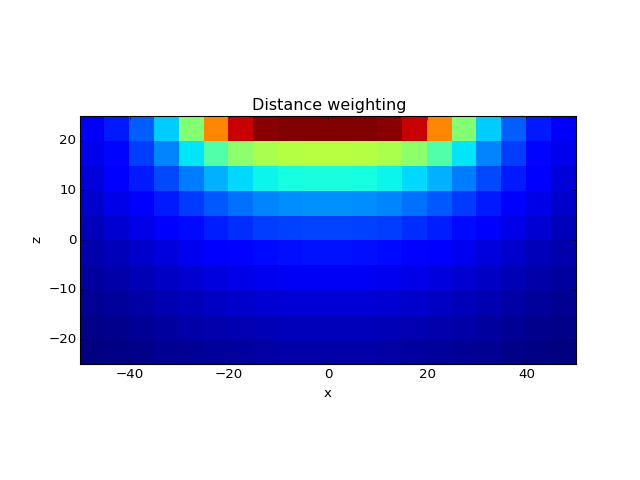

In [16]:
# Generate a distance weighting
wr = PF.Magnetics.get_dist_wgt(mesh,rxLoc,actv,3.,np.min(mesh.hx)/4)
wrMap = PF.BaseMag.WeightMap(mesh, wr)

plt.figure()
ax = subplot()
mesh.plotSlice(wr, ax = ax, normal = 'Y', ind=midx)
title('Distance weighting')
xlabel('x');ylabel('z')
plt.gca().set_aspect('equal', adjustable='box')

<IPython.core.display.Javascript object>


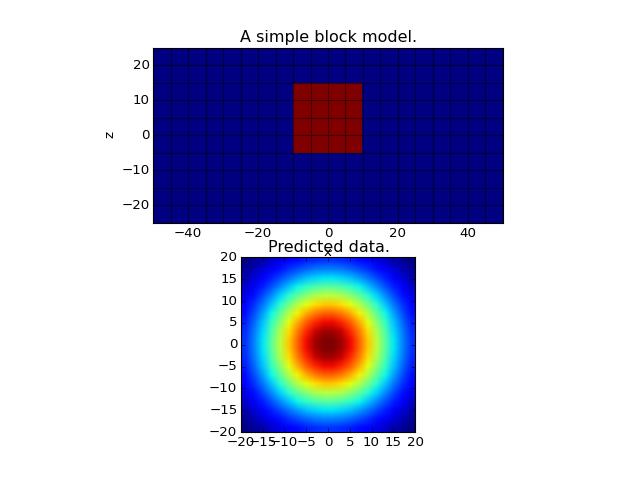

In [17]:
# We can now create a susceptibility model and generate data
# Lets start with a simple block in half-space
model = np.zeros((mesh.nCx,mesh.nCy,mesh.nCz))
model[(midx-2):(midx+2),(midy-2):(midy+2),-6:-2] = 0.01
model = mkvc(model)

# Create a few models
figure()
ax = subplot(211)
mesh.plotSlice(model, ax = ax, normal = 'Y', ind=midx, grid=True)
title('A simple block model.')
xlabel('x');ylabel('z')
plt.gca().set_aspect('equal', adjustable='box')

# We can now generate data
data = F.dot(model)  #: this is matrix multiplication!!
subplot(212)
imshow(data.reshape(X.shape), extent=[xr.min(), xr.max(), yr.min(), yr.max()])
title('Predicted data.')
plt.gca().set_aspect('equal', adjustable='box')


In [18]:
class LinearSurvey(Survey.BaseSurvey):
    def projectFields(self, u):
        return u
    
    @property
    def nD(self):
        return self.prob.G.shape[1]

class LinearProblem(Problem.BaseProblem):
    
    surveyPair = LinearSurvey

    def __init__(self, mesh, G, **kwargs):
        Problem.BaseProblem.__init__(self, mesh, **kwargs)
        self.G = G

    def fields(self, m):
        return self.G.dot(m)

    def Jvec(self, m, v, u=None):
        return self.G.dot(v)

    def Jtvec(self, m, v, u=None):
        return self.G.T.dot(v)


Once we have our problem, we can use the inversion tools in SimPEG to run our inversion:

In [19]:
prob = LinearProblem(mesh, F)
prob.solverOpts['accuracyTol'] = 1e-4
survey = LinearSurvey()
survey.pair(prob)
#survey.makeSyntheticData(data, std=0.01)
survey.dobs=data
survey.mtrue = model


reg = Regularization.Tikhonov(mesh, mapping=wrMap)
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.Wd = np.ones(len(data))*1.
opt = Optimization.ProjectedGNCG(maxIter=6,lower=0.,upper=1.)
opt.tolX = 1e-10
# opt = Optimization.InexactGaussNewton(maxIter=6)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
beta = Directives.BetaSchedule()
betaest = Directives.BetaEstimate_ByEig(beta0_ratio = 10**-10)
target = Directives.TargetMisfit()
inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest, target])
reg.alpha_s =0.0025
m0 = np.ones_like(survey.mtrue)*1e-4

Explore the documentation to see what other parameters you can tweak in the different elements of the inversion, but let's check how well we recovered the model just by using the default parameters:

In [20]:
mrec = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same solver as the problem***
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  1.13e-02  5.62e+04  2.15e-07  5.62e+04    5.06e+01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 5.6238e+03
0 : |xc-x_last| = 3.9811e-02 <= tolX*(1+|x0|) = 1.0063e-10
0 : |proj(x-g)-x|    = 5.0612e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 5.0612e+01 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =       6    <= iter          =      1
------------------------- DONE! -------------------------


In [21]:
np.nan <= 0.1

False

<IPython.core.display.Javascript object>


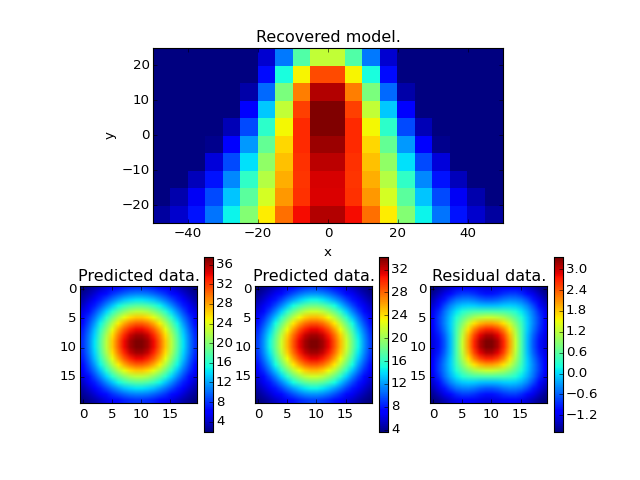

<matplotlib.colorbar.Colorbar instance at 0x000000001AD3C488>

In [22]:
# Here is the recovered susceptibility model
plt.figure()
ax = subplot(211)
mesh.plotSlice(mrec, ax = ax, normal = 'Y', ind=10)
title('Recovered model.')
xlabel('x');ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')

# Plot predicted data and residual
pred = F.dot(mrec)  #: this is matrix multiplication!!

subplot(234)
imshow(data.reshape(X.shape))
title('Predicted data.')
plt.gca().set_aspect('equal', adjustable='box')
colorbar()

subplot(235)
imshow(pred.reshape(X.shape))
title('Predicted data.')
plt.gca().set_aspect('equal', adjustable='box')
colorbar()

subplot(236)
imshow(data.reshape(X.shape) - pred.reshape(X.shape))
title('Residual data.')
plt.gca().set_aspect('equal', adjustable='box')
colorbar()

Hopefully you now have an idea of how to create a Problem class in SimPEG, and how this can be used with the other tools available.

In [ ]:
class MagProblem(object):
    
    def __init__(self, mesh, **kwargs):
        self.mesh = mesh
        Utils.setKwargs(self, **kwargs)
    
    @property
    def dtype(self):
        return getattr(self, '_dtype', 'tmi')
    @dtype.setter
    def dtype(self, val):
        assert type(val) is str, 'dtype must be a string'
        assert val in ['tmi', 'xyz'], 'dtype must be either "tmi" or "xyz"'
        self._dtype = val
    
    

In [ ]:
p = MagProblem(M, dtype='xyz')

In [ ]:
p.dtype

In [ ]:
p.dtype

In [ ]:
d.height = 4
print d.height

In [ ]:
M = Mesh.TensorMesh([5,5])

In [ ]:
M._cellGrad